In [1]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [2]:
# Import relevant packages.
using DataFrames
using CSV
using ProgressBars
using StatsPlots

In [68]:
# Load withdraw and deposit data.
withdraw_transactions_df = CSV.read("../data/lighter_complete_withdraw_txs.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/lighter_complete_deposit_txs.csv", DataFrame);

In [73]:
CSV.write("../data/deposit_addresses.csv", deposit_transactions_df[!, [:from_address]] |> unique)
CSV.write("../data/withdraw_addresses.csv", withdraw_transactions_df[!, [:recipient_address]] |> unique)

"../data/withdraw_addresses.csv"

In [5]:
# Lets load the transactions_of_deposit_addresses, a dataframe that contains all the transactions that include
# a deposit addresses. (transaction.to_address in deposit_addresses or transaction.from_address in deposit_addresses).
# Since we are looking for transactions between two EOA addresses that involve some cryptocurrency amount,
# the transactions where value == 0 were left apart.
transactions_of_deposit_addresses =  CSV.read("../data/transactions_between_deposit_and_withdraw_addresses.csv", DataFrame)
#transactions_of_deposit_addresses_2 =  CSV.read("../data/transactions_between_deposit_and_withdraw_addresses.csv", DataFrame)

,Column1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
,Int64,String,Int64,Int64,String,String,Float64,Int64,Int64,Int64,Int64,Missing,String?,Float64?,String,Int64,String,Float64?,Float64?,Float64?,Int64
1,0,0x95a985c3cdb846eb9e681b4a5504252476a4526533194ff55e188c6a287faea5,660,445,0xde33e58f056ff0f23be3ef83ab6e1e0bec95506f,0x0000000000811324e341265fb81e635119b32a27,6.10651e17,21000,315458825961,24173642,21000,missing,missing,1.0,2021-09-07 16:06:46+00:00,13179623,0xed5a7fb952972ec31d1e4749209ce973c4485a4336955b934fb8ef9e656a0dae,3.9468e11,5.05627e9,2.0,315458825961
2,1,0x2283052990d67e9edb413680a586bd21c73ad89a9c127eee4298dadd8636f3ec,1679,212,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,36620109608,18840054,21000,missing,missing,1.0,2021-08-18 21:46:47+00:00,13051722,0x49275b4abd649d6e7809d4cb6f706ed5202793c488145cbab5e0cd9bbed5c798,5.09882e10,4.0e9,2.0,36620109608
3,2,0x6060a52af5acb6e94b576cd17610946228c54ca41a1f547c159bda7260277e5f,1994,265,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,233851350688,13924789,21000,missing,missing,1.0,2021-11-02 01:29:41+00:00,13534695,0x4f281a72e3f4ac513ae9c3bbe217e1ee7989c62b2606e2ce95e9914eeb892e90,2.82298e11,2.425e9,2.0,233851350688
4,3,0x6d75a599e245fcc41f7918a82a1cfb306e7785eabe515d0887a70b040421b881,1996,267,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,233851350688,13966789,21000,missing,missing,1.0,2021-11-02 01:29:41+00:00,13534695,0x4f281a72e3f4ac513ae9c3bbe217e1ee7989c62b2606e2ce95e9914eeb892e90,2.82298e11,2.425e9,2.0,233851350688
5,4,0x19ef65dab5504b0489c89cd9a31d348111bfe25d5a1bbb1367b1777b154acaac,1581,92,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,1462996670392,29943331,21000,missing,missing,1.0,2021-08-15 19:05:19+00:00,13031548,0x7ff94f67fd4a7895cb3e87c03377a906363164b817078373c77314b01fd7142f,1.463e12,1.33813e12,2.0,1462996670392
6,5,0x08c6d7f02cfa25e2a5ea793a6e626a5cebd851f7cded076d3eb82789dd12518a,1908,127,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,1000000,90522296947,9060649,21000,missing,missing,1.0,2021-10-01 17:16:32+00:00,13334772,0xdf6cd671bca9f2c1a1cbf1e4ce88e32e70cb026a9ae85f38af95d5d07a96e2b3,1.08182e11,1.65e9,2.0,90522296947
7,6,0xe0e369f1593a55d7ee95f8c898884f4af87d940d00e9d66daa6d7ec3307e78fa,1984,75,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,200783732420,3930653,21000,missing,missing,1.0,2021-11-01 23:49:48+00:00,13534229,0x2aa0e35e62b93f7fc7ccad5ae19e366ca2eb461b7b25a78625c26737eb179fc5,3.168e11,5.0e9,2.0,200783732420
8,7,0x20e2f0d3bd9e12acab8a54df7689fcc48a772b6ade7f65e2aad7737b7e132900,594,235,0xe747c2d98e21de4f170fb65e84e8fa2f840c6e1c,0x00000000009a41862f3b2b0c688b7c0d1940511e,9.0e17,21000,59403534848,18922499,21000,missing,missing,1.0,2021-09-17 05:10:16+00:00,13241285,0x467e4c66a9bffa546ba36fba3522fd5c4bd112c8c8de80c1a6dcabcd4c0455e5,8.11239e10,1.65e9,2.0,59403534848
9,8,0xd3be837eec2a704069ee6119609f7195bd1c3f6a8e7485b2fe51181288166adb,1734,135,0x00000000009a41862f3b2b0c688b7c0d1940511e,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,21000,65715134533,11751359,21000,missing,missing,1.0,2021-08-29 02:24:01+00:00,13117679,0xb0a249f48d2d7a4c66a4110e2def1a2901836ddfc50744876be075939348caab,7.0e10,5.0e8,2.0,65715134533


### function linked_transactions_heuristic
The input DataFrame `transactions_of_deposit_addresses` contain transactions that involve deposit_addresees.
We want to link the input `withdraw_transaction` with a transaction inside the `transactions_of_deposit_addresses`. So, the  `linked_transactions_heuristic` function retuns all the transactions inside the `transactions_of_deposit_addresses` that involve the `withdraw_transaction.recipient_address` and where made before `withdraw_transaction.block_timestamp` 

Important: The input `transactions_of_deposit_addresses` must be sorted  by the column `block_timestamp` 

In [6]:
function linked_transactions_heuristic(transactions_of_deposit_addresses, withdraw_transaction)
    linked_transactions = DataFrame(  withdraw_address = String[], deposit_address = String[], transaction_hash = String[])
    
        for transaction in eachrow(transactions_of_deposit_addresses)
            if transaction.block_timestamp > withdraw_transaction.block_timestamp 
                break
            elseif transaction.from_address == withdraw_transaction.recipient_address
                push!(linked_transactions, [withdraw_transaction.recipient_address, transaction.to_address, transaction.hash ])
            elseif transaction.to_address == withdraw_transaction.recipient_address
                push!(linked_transactions, [withdraw_transaction.recipient_address, transaction.from_address, transaction.hash])
            end
        end

    
    return linked_transactions
end

linked_transactions_heuristic (generic function with 1 method)

In [81]:
# Lets test the function
sorted_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp )
sorted_transactions_of_deposit_addresses = sort(transactions_of_deposit_addresses, :block_timestamp )
linked_transactions_heuristic(sorted_transactions_of_deposit_addresses,sorted_withdraw_transactions_df[80700, :])

,withdraw_address,deposit_address,transaction_hash
,String,String,String
1,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x806e3751307df85158db59247bf43ac4a76dd0854d76ab3a6d6ed37ab440fe63
2,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x7a1f9f767d5737e549a404a1af933b12f4a6f048,0x518239c5c71ba0e2b805e6e8ed39849c30fdad90aaeced8f4867e2784f7d18fd
3,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x8d46fa21b07ea83b9d3baee77fa11055a1e162d21141feb33d1ecd9267e793ae
4,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x3829547cb1cb5154e6753e6832468f74a94adec19bc6bf610d5b003fbc775177
5,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0x450551e229202bc643b3f45df8721b921869bd43f4b0936ae9cbc00b4a450ca0
6,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xbccdc6d1572ce74be0c6836460e0a40bbf8ead07031ec4d3554851e66c94de80
7,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0x0557533e68c813a2bba37ca389233f7618c9327657ccd1cac89ee832dc1be568
8,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0x510059633c4958d43dfbc50b3b1a4ce6b9cb871a,0x1743d7077af28de73217ee384aff0532944b47183981ae8184bbfecde1eba728
9,0xee439ee079ac05d9d33a6926a16e0c820fb2713a,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0x6aa263dd363ba99c433a8a4c9e6bfe8a120662029bf1c545fa11644ad04ce8dc


### function apply_linked_transactions_heuristic
Apply the `linked_transactions_heuristic` function to each withdraw of the input `withdraw_transactions_df` DataFrame.
Retuns a DataFrame with the columns: `withdraw_address`, `deposit_address` and `transaction_hash`.
You can read this DataFrame in the following way:
The `withdraw_address` is linked to the  `deposit_address` by the transaction `transaction_hash`

In [8]:
# Auxiliary function
function add_linked_transactions(linked_transactions, new_linked_transactions)
    for transaction in eachrow(new_linked_transactions)
        if transaction.transaction_hash ∉ linked_transactions.transaction_hash
            push!(linked_transactions, transaction)
        end
    end
    return linked_transactions
end
    

add_linked_transactions (generic function with 1 method)

In [9]:
function apply_linked_transactions_heuristic(transactions_of_deposit_addresses, withdraw_transactions_df)
    sorted_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp )
    sorted_transactions_of_deposit_addresses = sort(transactions_of_deposit_addresses, :block_timestamp )
    
    linked_transactions = DataFrame( withdraw_address = String[], deposit_address = String[], transaction_hash = String[])
    for withdraw_transaction in ProgressBar(eachrow(sorted_withdraw_transactions_df), printing_delay= 30)
        linked_transactions = add_linked_transactions(linked_transactions, linked_transactions_heuristic(sorted_transactions_of_deposit_addresses, withdraw_transaction))
    end

    
    return linked_transactions
end

apply_linked_transactions_heuristic (generic function with 1 method)

In [11]:
@time results = apply_linked_transactions_heuristic(transactions_of_deposit_addresses, withdraw_transactions_df)

0.0%┣                                     ┫ 0/83.8k [00:30<-698:-11:00, -30s/it]
0.0%┣                                        ┫ 1/83.8k [00:30<Inf:Inf, InfGs/it]
8.9%┣███▋                                    ┫ 7.5k/83.8k [01:00<10:14, 124it/s]
13.5%┣█████▏                                ┫ 11.3k/83.8k [01:30<09:40, 125it/s]
16.8%┣██████▍                               ┫ 14.0k/83.8k [02:00<09:57, 117it/s]
19.7%┣███████▌                              ┫ 16.5k/83.8k [02:30<10:12, 110it/s]
22.5%┣████████▌                             ┫ 18.8k/83.8k [03:00<10:22, 104it/s]
25.0%┣█████████▌                            ┫ 21.0k/83.8k [03:30<10:30, 100it/s]
27.4%┣██████████▊                            ┫ 22.9k/83.8k [04:00<10:38, 95it/s]
29.5%┣███████████▌                           ┫ 24.7k/83.8k [04:30<10:46, 91it/s]
31.5%┣████████████▎                          ┫ 26.4k/83.8k [05:00<10:55, 88it/s]
33.3%┣█████████████                          ┫ 27.9k/83.8k [05:30<11:03, 84it/s]
34.8%┣█████████████▋        

2438.417432 seconds (50.14 G allocations: 747.634 GiB, 5.90% gc time)


100.0%┣██████████████████████████████████████┫ 83.8k/83.8k [41:06<00:00, 34it/s]


,withdraw_address,deposit_address,transaction_hash
,String,String,String
1,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x55e2780588aa5000f464f700d2676fd0a22ee160,0xa5bd1dffc78fa0d1d49b0f66fb069d30a292c0f4090196e4a7ed5db1cb27b7a9
2,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x5fe555dfba191f44bf2cb085deb3c3f8e1d1e90151e727b7e9ebc0c18c4432d5
3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x5b035467fee5c884c36e5eec793ac746391ab9162f49322643eb23f3fe13921d
4,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x5fc94341ba178e4ca1e2069baeb8e3fd1201cbb0,0xd37b2a60d6de81bd58eca811fb511d8bbed30f3d8a62b6eb6cb505585f1cd2e1
5,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x7471f5cbacb71968bf5816d19a4bf3f6bd863b88b6ad467e450382a60ff5f72e
6,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x5fc94341ba178e4ca1e2069baeb8e3fd1201cbb0,0x95aa6281da2b63b8fc0f0a11b13ce42f961ad3c131ca93109d538853a0914747
7,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0xa3f2bb469016abc81e8d9315fdfa787997457dc5bbf88e6898364a2db9d9c962
8,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x4a6f9846fbbde38fe51147b0e6c274a607e2b7b0,0x379f0696a50123ac7917943815b72540159b737df8ac76e0c9ed3f4e8b06228a
9,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x2ea70aea444d26597eca601d210d2b9ce2cdf999627afa6bd205d5792df97c64


In [99]:
results_2 = apply_linked_transactions_heuristic(transactions_of_deposit_addresses[1:2000, :], withdraw_transactions_df)

0.0%┣                                     ┫ 0/83.8k [00:30<-698:-11:00, -30s/it]
0.0%┣                                        ┫ 1/83.8k [00:30<Inf:Inf, InfGs/it]
100.0%┣████████████████████████████████████┫ 83.8k/83.8k [00:40<00:00, 2.1kit/s]


,withdraw_address,deposit_address,transaction_hash
,String,String,String
1,0x2bc6511b781ce3337e265c6112b2af56c73542b5,0x2bc6511b781ce3337e265c6112b2af56c73542b5,0xf062f2217eab91df05382153d94df790d0c2efd0167d21a325b82f241b89278f
2,0x444444cc7fe267251797d8592c3f4d5ee6888d62,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0xcad2c8ff3c1a099ec149da0ce261991acbeefd3cead7a72affcef686828ff0ad
3,0x988a311ecf1ab685705e9b767278a1537fdb66cb,0x3638d7bcafe5deeeb2e8f834b7425363997c81fc,0x18767f00c7da9d03880b0a08d238f0ddd9440c335ddfc97375e5fd4b67de7f59
4,0x16022a5194f21d34c476ad407391e7d00f885df1,0x16022a5194f21d34c476ad407391e7d00f885df1,0x6ac5f4e247fd4a1695660f27e4410897f5574f6bbe111bf8d2c1582688d9f76f
5,0x57baff1c21ac5a1e9f9a0638596d009da1a2d2ef,0x1d5ba2927328e92d3cb88b45f83d72da35927476,0xf9894593b19602838aa94fcf440ac5694a3edf547dfd95a0d47bbc5a49599431
6,0x1d55cdbb71827e89c98841f8a52ac84d025558a1,0x1d55cdbb71827e89c98841f8a52ac84d025558a1,0x0beb591f14f36b7b0d7e3ee9553e6f95d4ee4d85670a45dc1974ecb0d27c1453
7,0x1c053ccbca2784b8b5eea4b51eb6ad9cb10a54b8,0x4602525fdeee4084ae863c5a81d605b498f4714e,0xd468fe1e029028de352e4aa2cd9514fad2e87c09a03708c252dc86ac4334ff2a
8,0x1c053ccbca2784b8b5eea4b51eb6ad9cb10a54b8,0x4602525fdeee4084ae863c5a81d605b498f4714e,0xe26b89d5fa83e84a34cd9f6f8e0fc84d19642945b33d96b6cfcda430fe94eb70
9,0x1c053ccbca2784b8b5eea4b51eb6ad9cb10a54b8,0x4602525fdeee4084ae863c5a81d605b498f4714e,0x979dbeacad437a013aef94276b4ca9d1f9829b78bf497d256a9f18cca2b8d201


In [112]:
# Auxiliary function

function add_linked_transactions_2(linked_transactions, new_linked_transactions)
    for transaction in eachrow(new_linked_transactions)
        if transaction.transaction_hash ∉ linked_transactions.transaction_hash
            push!(linked_transactions, transaction)
        else
            "printa KAKAAAAAAAAAAAAA KAKA KAKA KAKA AAAAAAAAAA"
        end
    end
    return linked_transactions
end

function apply_linked_transactions_heuristic_2(transactions_of_deposit_addresses, withdraw_transactions_df)
    sorted_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp )
    sorted_top_to_bottom_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp, rev = true)
    sorted_transactions_of_deposit_addresses = sort(transactions_of_deposit_addresses, :block_timestamp )
    checked_withdraw_addresses = []
    
    
    linked_transactions = DataFrame( withdraw_address = String[], deposit_address = String[], transaction_hash = String[])
    for withdraw_transaction in ProgressBar(eachrow(sorted_top_to_bottom_withdraw_transactions_df), printing_delay= 30)
        if withdraw_transaction.recipient_address ∉ checked_withdraw_addresses
            push!(checked_withdraw_addresses, withdraw_transaction.recipient_address)
            linked_transactions = add_linked_transactions_2(linked_transactions, linked_transactions_heuristic(sorted_transactions_of_deposit_addresses, withdraw_transaction))
        end
    end
    

    
    return linked_transactions
end


    

apply_linked_transactions_heuristic_2 (generic function with 1 method)

In [113]:
results_3 = apply_linked_transactions_heuristic_2(transactions_of_deposit_addresses[1:2000, :], withdraw_transactions_df)



0.0%┣                                     ┫ 0/83.8k [00:30<-698:-11:00, -30s/it]
0.0%┣                                        ┫ 1/83.8k [00:30<Inf:Inf, InfGs/it]
83.9%┣███████████████████████████████      ┫ 70.3k/83.8k [01:00<00:12, 1.2kit/s]
100.0%┣████████████████████████████████████┫ 83.8k/83.8k [01:15<00:00, 1.1kit/s]


,withdraw_address,deposit_address,transaction_hash
,String,String,String
1,0x362627a677a0a82261bfc3cc6c2df30f032c29c0,0x362627a677a0a82261bfc3cc6c2df30f032c29c0,0x7ad3bc6ea507e334e91c5ce05d933a9147e02c88a7adcaf714887764f0d586b1
2,0x362627a677a0a82261bfc3cc6c2df30f032c29c0,0x362627a677a0a82261bfc3cc6c2df30f032c29c0,0xc2bb8c72a750811b7316964a0b24bdae75fc8ed7689091c99258ce70fbb66fd4
3,0x362627a677a0a82261bfc3cc6c2df30f032c29c0,0x362627a677a0a82261bfc3cc6c2df30f032c29c0,0x792df786838180f4b0efa8398bbec3d63734ee4fc94702ca28604e9cc29f751d
4,0x26db774e3c5ed9d8930e89aadd598cb6e498d369,0xf354d776288eff3a9b860945c2066936fd5a79e1,0xcc193dc6a99c2f7dbd8c7c8daebe9388cfe5bfc9eb5d718d4a62b8474167e0fe
5,0x26db774e3c5ed9d8930e89aadd598cb6e498d369,0xf354d776288eff3a9b860945c2066936fd5a79e1,0x1b2416d563eeee6e9d8e914a160796c1f65618318b3ed603c047183e222c255f
6,0x26db774e3c5ed9d8930e89aadd598cb6e498d369,0xf354d776288eff3a9b860945c2066936fd5a79e1,0xdf3b4856061d0552484fbf6d4e96947cf843103531465e8a2489ec0bf0d51b44
7,0x26db774e3c5ed9d8930e89aadd598cb6e498d369,0xf354d776288eff3a9b860945c2066936fd5a79e1,0x9ff3a82e6ad9741931302c6a1feb08d6125f2abac9ed92f7e5c3d1d6ba112e19
8,0x1dcc7f61c24a91eb00e26a56730c0879c275958a,0x9cce60314994ed6c1877c54efe6ada6c7908a602,0x41118b9b4bd5548daecdb380eccc6aea4a94cc62e3a2036592c7f05b28b9e1db
9,0x0b7c43af43d76f79b6f6cfbafb3a01dde0468225,0x0b7c43af43d76f79b6f6cfbafb3a01dde0468225,0xb29c00194675a63e6f34245b506d0a5a5987b822bc3e8102de288bfd29035211


In [111]:
results_2

,withdraw_address,deposit_address,transaction_hash
,String,String,String
1,0x2bc6511b781ce3337e265c6112b2af56c73542b5,0x2bc6511b781ce3337e265c6112b2af56c73542b5,0xf062f2217eab91df05382153d94df790d0c2efd0167d21a325b82f241b89278f
2,0x444444cc7fe267251797d8592c3f4d5ee6888d62,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0xcad2c8ff3c1a099ec149da0ce261991acbeefd3cead7a72affcef686828ff0ad
3,0x988a311ecf1ab685705e9b767278a1537fdb66cb,0x3638d7bcafe5deeeb2e8f834b7425363997c81fc,0x18767f00c7da9d03880b0a08d238f0ddd9440c335ddfc97375e5fd4b67de7f59
4,0x16022a5194f21d34c476ad407391e7d00f885df1,0x16022a5194f21d34c476ad407391e7d00f885df1,0x6ac5f4e247fd4a1695660f27e4410897f5574f6bbe111bf8d2c1582688d9f76f
5,0x57baff1c21ac5a1e9f9a0638596d009da1a2d2ef,0x1d5ba2927328e92d3cb88b45f83d72da35927476,0xf9894593b19602838aa94fcf440ac5694a3edf547dfd95a0d47bbc5a49599431
6,0x1d55cdbb71827e89c98841f8a52ac84d025558a1,0x1d55cdbb71827e89c98841f8a52ac84d025558a1,0x0beb591f14f36b7b0d7e3ee9553e6f95d4ee4d85670a45dc1974ecb0d27c1453
7,0x1c053ccbca2784b8b5eea4b51eb6ad9cb10a54b8,0x4602525fdeee4084ae863c5a81d605b498f4714e,0xd468fe1e029028de352e4aa2cd9514fad2e87c09a03708c252dc86ac4334ff2a
8,0x1c053ccbca2784b8b5eea4b51eb6ad9cb10a54b8,0x4602525fdeee4084ae863c5a81d605b498f4714e,0xe26b89d5fa83e84a34cd9f6f8e0fc84d19642945b33d96b6cfcda430fe94eb70
9,0x1c053ccbca2784b8b5eea4b51eb6ad9cb10a54b8,0x4602525fdeee4084ae863c5a81d605b498f4714e,0x979dbeacad437a013aef94276b4ca9d1f9829b78bf497d256a9f18cca2b8d201


In [104]:
results_3[!,:transaction_hash] |> unique

27-element Vector{String}:
 "0xf062f2217eab91df05382153d94df790d0c2efd0167d21a325b82f241b89278f"
 "0x6ac5f4e247fd4a1695660f27e4410897f5574f6bbe111bf8d2c1582688d9f76f"
 "0xf9894593b19602838aa94fcf440ac5694a3edf547dfd95a0d47bbc5a49599431"
 ⋮
 "0xdf3b4856061d0552484fbf6d4e96947cf843103531465e8a2489ec0bf0d51b44"
 "0x9ff3a82e6ad9741931302c6a1feb08d6125f2abac9ed92f7e5c3d1d6ba112e19"

In [ ]:
results_4 = apply_linked_transactions_heuristic_2(transactions_of_deposit_addresses, withdraw_transactions_df)

0.0%┣                                     ┫ 0/83.8k [00:30<-698:-11:00, -30s/it]
0.0%┣                                        ┫ 1/83.8k [00:30<Inf:Inf, InfGs/it]
1.8%┣▊                                        ┫ 1.5k/83.8k [01:00<53:13, 26it/s]
4.1%┣█▊                                       ┫ 3.4k/83.8k [01:30<35:02, 38it/s]
5.7%┣██▍                                      ┫ 4.8k/83.8k [02:00<33:09, 40it/s]
7.6%┣███                                      ┫ 6.3k/83.8k [02:30<30:37, 42it/s]


In [90]:
sorted_withdraw_transactions_df = sort(withdraw_transactions_df, :block_timestamp, rev = true )

,Column1,Unnamed: 0,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,tornado_cash_address,recipient_address
,Int64,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Float64?,Float64?,Float64?,Int64,String,String
1,79097,172812,0xd1fa93763d61b51204647ea0607a613adcdf6439988277d6a2b363394a3dda5d,7302,228,0xa0f0287683e820ff4211e67c03cf46a87431f4e1,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,213352167549,15113987,376458,missing,missing,1,2021-10-26 20:19:34 UTC,13495071,0x5bc712de36cb8204571a3b6b8f49f34b8e1870a05cb8deb9b56108bb12f3103c,2.44761e11,3.0e9,2.0,213352167549,0x910cbd523d972eb0a6f4cae4618ad62622b39dbf,0x4718ce007293bce1e514887e6f55ea71d9a992d6
2,77343,171015,0x1b76dd2e1e5eae1fcfff670250bf2ee4efda25c2090ac54f77fc7ade9817c74d,9674,413,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,222277467553,28310297,401494,missing,missing,1,2021-10-26 20:09:20 UTC,13495031,0x7dc2c325b46d30e8b0ee3aa67eb5f02554f16ddec7e0cf9b2bfe89de356b3335,2.74695e11,3.0e9,2.0,222277467553,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x453d9a9d4ac89636e314857cde3aee69538b5f1c
3,80875,174597,0x9f0a80c5ff4c299c6bac9f17fa569659ed8f8eaeae60f41a7f7444840de6d541,9673,130,0xbe4d1e137a24af091be80ae58d652279665e3a27,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,148362290558,6179438,376482,missing,missing,1,2021-10-26 19:30:30 UTC,13494861,0x981a05dd715147838d05d53c99a480f09fefd210effc7dd0efe7065c3530d321,1.59001e11,3.0e9,2.0,148362290558,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0x972b017f633252e3046abbd4ab74e59d9b6791d8
4,75819,169483,0x45090f99e58e2238f176ce90cea633764bcabb8f3695051887103dc258e6a30b,7301,268,0xa0f0287683e820ff4211e67c03cf46a87431f4e1,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,126693001217,17227910,401470,missing,missing,1,2021-10-26 19:25:24 UTC,13494840,0x82e2468161c24a4873fa15730d68fff971e1328080dfffde46b1adac969f91c1,1.61359e11,3.0e9,2.0,126693001217,0x910cbd523d972eb0a6f4cae4618ad62622b39dbf,0x9f49452b752ffc40e3f9f1b2c043f12af3194bd1
5,79336,173051,0x59f70f76964d5d8ac94f2666d8bd494e9cca4cf797fcc33b913b10db733086a8,3815,172,0x49136693081f2c18e2cf14428dd78cd90a22dc1f,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,162577699299,9958004,376458,missing,missing,1,2021-10-26 19:02:50 UTC,13494737,0x21e4ce7cf08b6235c595a8db44f0818bebe6bb5c56dbfbae4397f63281361f9c,1.6663e11,3.0e9,2.0,162577699299,0x910cbd523d972eb0a6f4cae4618ad62622b39dbf,0x88c68ae53d29a54fd694c5aded16370e74dd2cd7
6,78505,172216,0xe284ff50c609c010a0a62ba7402abd3573761e5127766e79bcd80ada777ba49e,3814,259,0x49136693081f2c18e2cf14428dd78cd90a22dc1f,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,147178378408,14950308,376446,missing,missing,1,2021-10-26 18:57:01 UTC,13494709,0x2276d9a5f10b0e74c5956ec341a88687c64c1db6b25124b99ab040f41341cb81,1.66524e11,3.0e9,2.0,147178378408,0x910cbd523d972eb0a6f4cae4618ad62622b39dbf,0x88c68ae53d29a54fd694c5aded16370e74dd2cd7
7,75871,169535,0x1132095ceacbf4d7be721d13e148c3fe21d83e6d74f18f9bf5a2bccd1f27b459,5361,54,0x20bb3095a4852f4c97d7a188e9f7183c85acfc49,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,176088549332,3200208,401470,missing,missing,1,2021-10-26 18:52:50 UTC,13494691,0xa4f7ad02d31db91ef5788221f044b818a645ef49994c748210df23d1533dd1f2,1.91798e11,3.0e9,2.0,176088549332,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0xf28d29e749bbde5954557ab6ad521187c125bc61
8,80097,173816,0x6fbd64bbb6902e6f672ffe5ec2e9c6e45d6899077b2e78ec5fd003602d52d53b,3813,320,0x49136693081f2c18e2cf14428dd78cd90a22dc1f,0x722122df12d4e14e13ac3b6895a86e84145b6967,0,550000,166266453116,18155882,376470,missing,missing,1,2021-10-26 18:51:43 UTC,13494688,0x8b66eb694836c75c866c2d2e31af73c4f20f6ab46f965

In [86]:
(results.transaction_hash |> length) - (results.transaction_hash |> unique |> length)

0

Lets inspect the results

In [12]:
groupby_results = sort(combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count), :count, rev = true)

,withdraw_address,deposit_address,count
,String,String,Int64
1,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,4136
2,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,1163
3,0x9dfac9bbe1119da5dcdd7b095db40920cde878ef,0xe5818d70a9b5aed2bfde4e41fbcb07dd80f8fc84,344
4,0x73b687a6cfe7271a31ac563e8703ae787878613c,0xcf701308663a495637f4131f7d3644372e170e5b,279
5,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,271
6,0xa8015df1f65e1f53d491dc1ed35013031ad25034,0x8298c072baa440607c1f83b4024c0b4c47fcd163,231
7,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,231
8,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,197
9,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,171


In [13]:
#CSV.write("../data/heuristic_3_groupby_results.csv", get_linked_addresses(groupby_results))

In [14]:
groupby(groupby_results, :deposit_address)

,withdraw_address,deposit_address,count
,String,String,Int64
1,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,4136
2,0xd0600f3c676c777a24c44a15142f53699b6f2d45,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,18
3,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,13
,withdraw_address,deposit_address,count
,String,String,Int64
1,0xc6d5400d2c9e4fd391d6e1d99dcd5578ad59ca48,0x4286e22958fa72391604a691aca3fe832870a82f,1


In [15]:
groupby_results = sort(combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count), :count, rev = true)

,withdraw_address,deposit_address,count
,String,String,Int64
1,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,0x1ba3e0f3b3a138c3386d37dc85b2f6a08cc2a42e,4136
2,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,0xd50db60e738d25ba1d21f444adb3dcdd4bdbb30e,1163
3,0x9dfac9bbe1119da5dcdd7b095db40920cde878ef,0xe5818d70a9b5aed2bfde4e41fbcb07dd80f8fc84,344
4,0x73b687a6cfe7271a31ac563e8703ae787878613c,0xcf701308663a495637f4131f7d3644372e170e5b,279
5,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,0xfea0904acc8df0f3288b6583f60b86c36ea52acd,271
6,0xa8015df1f65e1f53d491dc1ed35013031ad25034,0x8298c072baa440607c1f83b4024c0b4c47fcd163,231
7,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,0xb658952a1a6c830c1aad7abc701b6ba92c12df75,231
8,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,0x8bdbf4b19cb840e9ac9b1effc2bfad47591b5bf2,197
9,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,0x61572ca1c6d53011e9b5318aa26dd285c7df6997,171


As we can see some withdraw_address are linked to more than one deposit_address and viceversa.
We will define that a `withdraw_address`and a `deposit_address` are linked, in the cases that the `withdraw_address` is only linked to the `deposit_address` and the `deposit_address` is only linked to the `withdraw_address

In [26]:
# Auxiliary functions check if the given address is unique in the input column
function is_unique(address, column)
    return findall(row -> row == address, column ) |> length == 1 
end

is_unique (generic function with 1 method)

In [27]:
function get_linked_addresses(results)
    grouped_results = combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count)
    withdraw_addresses = grouped_results[!, :withdraw_address]
    deposit_addresses = grouped_results[!, :deposit_address]
    linked_addresses = Dict()
    for row ∈ eachrow(grouped_results)
        if is_unique(row.withdraw_address, withdraw_addresses) && is_unique(row.deposit_address, deposit_addresses)
            linked_addresses[row.withdraw_address] = row.deposit_address
        end
    end
    return linked_addresses
end

get_linked_addresses (generic function with 1 method)

In [28]:
get_linked_addresses(results)

Dict{Any, Any} with 1753 entries:
  "0x3ff88ea59c108da5bac14d8bb87f1e6c22f6ee0d" => "0xaa018113d42ab7c467f383ef69400d083d5e0906"
  "0xf10de86fc53fb40b87bb1782982e90365716dc22" => "0xf10de86fc53fb40b87bb1782982e90365716dc22"
  "0xbcb77ac55027677b3118848b158ad731dd811e65" => "0xa49e0fe87ce0835fac09c3a883e103a658bc9efb"
  "0xcd438d3ac0b8d7490a716570f34e727a5f8f43c9" => "0xcd438d3ac0b8d7490a716570f34e727a5f8f43c9"
  "0x882c34e0a3405f713581b8c8c9650f3cc28df488" => "0x882c34e0a3405f713581b8c8c9650f3cc28df488"
  ⋮                                            => ⋮

In [54]:
cont = 0
for (key, value) in get_linked_addresses(results)
    if key == value 
        println(key)
        cont += 1
    end
end
cont

0xf10de86fc53fb40b87bb1782982e90365716dc22
0xcd438d3ac0b8d7490a716570f34e727a5f8f43c9
0x882c34e0a3405f713581b8c8c9650f3cc28df488
0x1ec35524abb179caf71631b1c8dd7fffbafaf1b6
0x3b3ab217313050a36c8c86fb036abc343d020fc0
0x8deb5646abb78064ed0029babdf4c33613e24bda
0xbfa43bf6e9fb6d5cc253ff23c31f2b86a739bb98
0xfa9dbab87da24fa3716c084cc8f9cc4f5e573849
0x9417ab659e81411dc3d0385b2dd27fa0a4f38392
0xae26e52d785fcd3a7dab7237c00dcc69d1ff759c
0x238926025e84475e3182774df480021470f8f978
0xf4dc836c2fb0e8edc82a5b02447d82bc859dbf47
0xe2abe2706a8bd68fe8ff82dda198e34c84ee5d76
0xeec965f24f046f66c53c7ae82efc7c0b6a44a938
0x1955c2b76b1cf245795950e75eb176080879da50
0xa07c565326376055dcfa206ef5b84ae471fb735b
0x4dabcbff6064c33d958b5aef91be814e3b7cf3ad
0x09bdff1a9d98a1fb81d982ad2b192dd49a932296
0xcbac7e254d2e026e52183322e1b8882aab4bf9a0
0xce31188cbd1d46bd33d9246f4a66068baf709a40
0x7a218b62ae9e23aac788979ead8be51258a3cbc5
0x4fdf425890adcc3ca34b97e9b0de56008c323a37
0x0cb48714989fa80cb5700cf849850ee4ff640f6d
0x6d244effc

0x020cf21cb58942e2c2fa355c4646d61b576e19c0
0xd461b2871b39e84fd33293b70254a6359f84dd45
0x5ac09356eebffa7bf20d55f1196f3e68b554fcae
0xd1ec22df6bb8004e6eaf6b893855a290f4e5ba3f
0xa4dc1fbe6002dc9e73cc2f58a9699bac1fdda341
0xc77fa6c05b4e472feee7c0f9b20e70c5bf33a99b
0xf7f189082878846c11a94ddac51c41afc7a7c772
0xe61cd5aa5ff1971f965865c4c57c77e15d258477
0xb21edcfbb2edbdfb3c8304c71235196483e6b8b3
0xa31d748cb54ce7b2fd926b4f764ad08cdd1cf84d
0x5780837c1d9ac3cd9b72203c8a0cfac73a9fc0b8
0x0abde5c47a88d01ee0f15c2a315a3223bb803905
0x52aafc6aa68238492235e6f8bc2bf7659464d09d
0xa1b38945846e1869b66ec19c196ba28506743dc0
0x03e7c739706e14ef8ab11953ae3562f4f612b01a
0xc68d61757a9894f34871c0ae733ac034d9abf807
0x47c9efe421b63bd802dcfc469704e159001f8c4b
0xf37ea78c0c4c44cbfd2e117c76fbae49fde289e6
0x29477a93e19f6c0469cb90bfd96123c6646ab443
0x38944b55598f7666a42047bb790bb3cede6c5368
0x774ff72b32ecd32f06b8e9254ff4a76bbc87ceca
0xd953ec22a7194f3505117ff6bf551c3146edaeb0
0x979ccb6f283612407a8776a757693710fce68de3
0x4614ec6b6

0xc82f5fcbfaaf7ca1f6d0a969db58a6bba2958840
0x986889008547d2f50e6eff01248ddea5a287185f
0xbfb910652f850f85e3f85aa0c12ae8f4037095b0
0x0e453834096b192845b0f53c0134cb1efdd964d2
0x9cc1ae3a31224920a47d4d859cdee7149da53e49
0xeea45c31b0131c41b7c8dc5a4a93feae475a80ca
0x0f7b2f5fd03573ec3a511998650cd2c852cb4420
0x68661550f759a41d65a8eefd3e47dd606ca76ae2
0xd0c352dbc3f03762421093ac7225224cca2f54f9
0x2414a1ba4691dd5da74686838ada4a5610d35934
0xa267f3a4a92531f47811e05e890e977a0fe375b4
0x08896945c5bd65cc8c216e7efd6969b9cc306ed5
0xcfa5a508f8cafa625b8675efe705fa8da8e49602
0x35c6432ebc042f0ec6490a6ef5f40423fd06019f
0xa41c00ecd32a2c94be29db5492875cdeacccbe0b
0x49979abf762409332464d81c933e608afffcc58d
0x867db38c83f4287a71ffd0cdfba6ffae93150ff7
0x00e17c3c7d6c1e1d35b7f7c22a90329abec7bb62
0x708370bfbbb8426eb440b11840030732dd4ef19a
0x36170b0fff983b1a9c5649673647790c2605df24
0xd74456abb45681953d0087ad5e20c1c08464835e
0x5e2a66bb11874bbd2109a1caf9ba5563293a403d
0xfe212078eb0e439e6f558193b69276186be2e246
0xfc23a2b93

670

In [55]:
length(get_linked_addresses(results))

1753

In [29]:
#CSV.write("../data/heuristic_3_linked_addresses.csv", get_linked_addresses(results))

### Results visualization

In [30]:
function get_histogram_data(results, withdraw_transactions_df)
    grouped_results = combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count)
    withdraw_addresses = grouped_results[!, :withdraw_address]
    deposit_addresses = grouped_results[!, :deposit_address]
    linked_addresses = Dict()
    
    ## Ver get addresses que solo se relacionan con 1 withdraw e iterar sobre eso
    for withdraw_address in withdraw_transactions_df[!, :recipient_address] |> unique
        linked_addresses[withdraw_address] = 0
    end
    
    for row ∈ eachrow(grouped_results)
        linked_addresses[row.withdraw_address] += 1
    end
    
    return linked_addresses
end

get_histogram_data (generic function with 1 method)

In [64]:
combine(groupby(results, [:withdraw_address, :deposit_address]), nrow => :count)

,withdraw_address,deposit_address,count
,String,String,Int64
1,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x55e2780588aa5000f464f700d2676fd0a22ee160,1
2,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,12
3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x5fc94341ba178e4ca1e2069baeb8e3fd1201cbb0,2
4,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x4a6f9846fbbde38fe51147b0e6c274a607e2b7b0,3
5,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x1a2952c9bc0177e5c40a22cfa00c9f0d0e2070d6,3
6,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0xa43ce8cc89eff3aa5593c742fc56a30ef2427cb0,4
7,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0x7e819419147fe92d64939dc3a9d7e409504eb9bc,1
8,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0xc8c30fa803833dd1fd6dbcdd91ed0b301eff87cf,3
9,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,0xe1846df99fdd930fe5585364b1e2eaa954b7d653,3


In [31]:
get_histogram_data(results, withdraw_transactions_df)

Dict{Any, Any} with 32528 entries:
  "0xab17da946b4ee971e6cd95f9784d664c074c1eae" => 0
  "0x3db8a6a96a8e3711c30c84d5bc26971ef61c549d" => 0
  "0x5d57f2e5f61b484eadc146fe245ff67cceb24497" => 0
  "0xce41f28db174e9684c84a1edcfddbebeaa22729d" => 0
  "0xe8c4d0b45cae962ea5fab9f797f49124c7e2d8ca" => 0
  ⋮                                            => ⋮

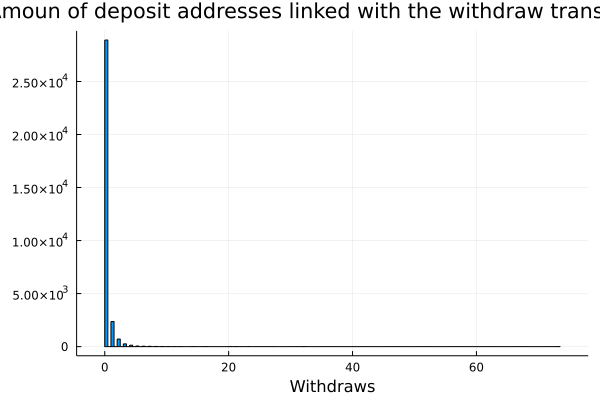

In [65]:
result_values = values(get_histogram_data(results, withdraw_transactions_df)) |> collect
histogram(result_values, bins= maximum(result_values)+100 ,legend=false, title="Amoun of deposit addresses linked with the withdraw transactions", xlabel="Withdraws")

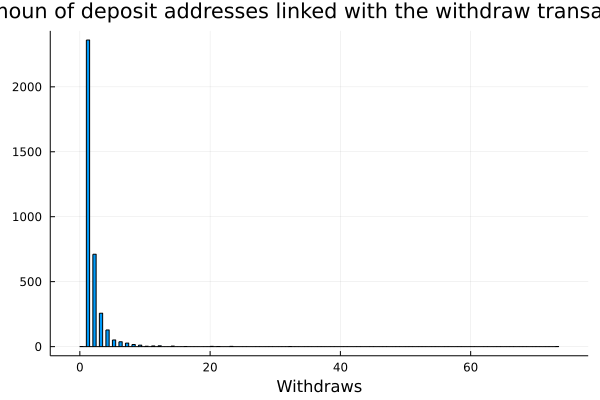

In [66]:
#Lets see only the withdraws that are linked to a deposit address
result_values = values(get_histogram_data(results, withdraw_transactions_df)) |> collect |> sort 
idx = findlast(score -> score == 0, result_values)
histogram(result_values[idx:length(result_values)], bins= maximum(result_values) + 100, legend=false,  title="Amoun of deposit addresses linked with the withdraw transactions", xlabel="Withdraws")